<a href="https://colab.research.google.com/github/daewoung/DLForMusicAndAudio_Study/blob/main/5th_Music_AutoTagging__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
DEV = 'cuda' # select your device 'cpu' or 'cuda'

In [3]:
import torch
import torch.nn as nn
import torchaudio
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import IPython.display as ipd
from datetime import datetime

def save_fig_with_date(figname):
  plt.savefig(f"{figname}_{datetime.now().strftime('%m_%d_%H_%M_%S')}.png")

In [ ]:
!pip install gdown
!gdown --id 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
!unzip -q mtat_8000.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
To: /content/mtat_8000.zip
100% 921M/921M [00:07<00:00, 121MB/s] 


In [1]:
!pip install torchaudio==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
torchaudio.__version__

'0.9.0'

#데이터 처리

In [6]:
class MTATDataset:
  def __init__(self, dir_path, split='train', num_max_data=4000, sr=16000):
    self.dir = Path(dir_path)
    self.labels = pd.read_csv(self.dir / "meta.csv", index_col=[0])
    self.sr = sr

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    self.labels = self.labels[:num_max_data]
    self.vocab = self.labels.columns.values[1:-1]
    self.label_tensor = self.convert_label_to_tensor()
  
  def convert_label_to_tensor(self):
    return torch.LongTensor(self.labels.values[:, 1:-1].astype('bool'))

  def __len__(self):
    return len(self.labels)
  

data_dir = Path('/content/MTAT_SMALL/')
dataset = MTATDataset(data_dir)

# 데이터 불러서 테스트

In [7]:
audio_path = dataset.labels['mp3_path'].iloc[0] #절대 path가 아님
audio_abs_path = data_dir/audio_path
audio_abs_path

PosixPath('/content/MTAT_SMALL/2/zephyrus-angelus-11-ave_maria__virgo_serena_josquin_des_prez-0-29.mp3')

In [36]:
y, sr = torchaudio.load(audio_abs_path)
ipd.Audio(y, rate = sr), dataset.vocab[torch.where(dataset.label_tensor[0])]
print(y.shape)
print(y[0])
print(y)

torch.Size([1, 465984])
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.7881e-07,
        -5.9605e-08, -5.9605e-08])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.7881e-07,
         -5.9605e-08, -5.9605e-08]])


In [48]:
a = torch.rand([2,5])
print(a)
print(a[1][:])

tensor([[0.2335, 0.3498, 0.3859, 0.3525, 0.0892],
        [0.2759, 0.7203, 0.1136, 0.3575, 0.0853]])
tensor([0.2759, 0.7203, 0.1136, 0.3575, 0.0853])


In [9]:
torch.where(dataset.label_tensor[0])

(tensor([ 7, 10, 48]),)

In [ ]:
dataset.labels.iloc[0]

In [ ]:
dataset.vocab 
#레이블들만 처리되어있다.

array(['singer', 'harpsichord', 'sitar', 'heavy', 'foreign', 'no piano',
       'classical', 'female', 'jazz', 'guitar', 'quiet', 'solo', 'folk',
       'ambient', 'new age', 'synth', 'drum', 'bass', 'loud', 'string',
       'opera', 'fast', 'country', 'violin', 'electro', 'trance', 'chant',
       'strange', 'modern', 'hard', 'harp', 'pop', 'female vocal',
       'piano', 'orchestra', 'eastern', 'slow', 'male', 'vocal',
       'no singer', 'india', 'rock', 'dance', 'cello', 'techno', 'flute',
       'beat', 'soft', 'choir', 'baroque'], dtype=object)

In [ ]:
dataset.label_tensor[0]
#텐서로 정의되어 있음.

tensor([[0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

In [ ]:
'''
torch.where
'''
torch.nonzero(dataset.label_tensor[100])

a = torch.tensor([1,0,1,0])
torch.nonzero(a)

tensor([[0],
        [2]])

#Make Dataset

In [214]:
class OnFlyDataset(MTATDataset):
  def __init__(self, dir_path, split='train', num_max_data=4000, sr=16000):
    super().__init__(dir_path, split, num_max_data, sr)

  def __getitem__(self, idx):
    audio_path = dataset.labels['mp3_path'].iloc[idx] #절대 path가 아님
    y, sr = torchaudio.load(self.dir / audio_path)
    
    if sr != self.sr:
      y = torch.functional.resample(y, orig_freq=sr, new_freq = self.sr)
    
    label = self.label_tensor[idx]
    return y[0], label

trainset = OnFlyDataset(data_dir)
validset = OnFlyDataset(data_dir, split='valid')
testset = OnFlyDataset(data_dir, split='test')

In [66]:
print(trainset[10], trainset[10][1])
trainset.vocab[torch.where(trainset[10][1])]


(tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -5.3644e-07,
         4.7684e-07,  1.1325e-06]), tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])) tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


array(['classical', 'quiet', 'ambient', 'string', 'harp', 'slow'],
      dtype=object)

#Make Model
- CNN

In [260]:
import torch.nn as nn
class SpecModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels):
    super().__init__()
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()
  
  def forward(self, x):
    mel_spec = self.mel_converter(x)
    return self.db_converter(mel_spec)

class AudioModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__()
    self.sr = sr
    self.spec_converter = SpecModel(sr, n_fft, hop_length, n_mels)
    self.conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
    )
    self.final_layer = nn.Linear(hidden_size, num_output)
    #class 별로 logit을 할당

  def get_spec(self, x):
    '''
    Get result of self.spec_converter
    x (torch.Tensor): audio samples (num_batch_size X num_audio_samples)
    '''
    return self.spec_converter(x)
  
  def forward(self, x):
    spec = self.get_spec(x) # num_batch X num_mel_bins X num_time_bins
    out = self.conv_layer(spec)
    out = torch.max(out, dim=-1)[0] # select [0] because torch.max outputs tuple of (value, index)
    logit = self.final_layer(out)
    prob = torch.sigmoid(logit)
    return prob
  

model = AudioModel(16000, 1024,512, 40, 128, 50)

#테스트

In [88]:
audio_sample, label = trainset[0]

In [95]:
spec = model.spec_converter(audio_sample)
# 한 프레임(시간) 당 40개의 특성을 가지고 있다.
spec.shape

torch.Size([40, 911])

In [102]:
spec = spec.unsqueeze(0)
spec.shape

torch.Size([1, 40, 911])

In [108]:
conv_layer = nn.Conv1d(in_channels = 40, out_channels = 16, kernel_size =1)
conv_layer_2 = nn.MaxPool1d(3)

print(conv_layer(spec).shape
a = conv_layer(spec) 
conv_layer_2(a).shape

torch.Size([1, 16, 911])


torch.Size([1, 16, 303])

# How To CNN Work

In [142]:
dummy = torch.randint(-3,4, (6,7)).float() #CNN은 float형식이여야 한다.
dummy = dummy.unsqueeze(0)
dummy = dummy.unsqueeze(0)

dummy.shape, print(dummy)

tensor([[[[ 3.,  1.,  0., -3.,  2.,  2., -1.],
          [ 2., -1.,  1.,  0.,  1.,  0., -1.],
          [-3., -3., -1.,  2.,  0.,  0.,  1.],
          [ 0.,  1.,  1.,  1., -1., -2.,  0.],
          [-2.,  3.,  2.,  0., -2., -1.,  1.],
          [ 1., -1., -2., -2.,  1.,  3.,  1.]]]])


(torch.Size([1, 1, 6, 7]), None)

In [125]:
conv_layer = nn.Conv2d(1, 1, kernel_size = 3, bias = False) # 3*3

In [135]:
conv_layer.weight.data = torch.randint(-1,2,(1,1,3,3)).float()
conv_layer.weight


Parameter containing:
tensor([[[[ 0.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0., -1.]]]], requires_grad=True)

- 2D Conv Layer의 입력은 3차원 

In [147]:
print(dummy) 
print(conv_layer.weight) 
print(conv_layer(dummy))
print(conv_layer(dummy).shape)

tensor([[[[ 3.,  1.,  0., -3.,  2.,  2., -1.],
          [ 2., -1.,  1.,  0.,  1.,  0., -1.],
          [-3., -3., -1.,  2.,  0.,  0.,  1.],
          [ 0.,  1.,  1.,  1., -1., -2.,  0.],
          [-2.,  3.,  2.,  0., -2., -1.,  1.],
          [ 1., -1., -2., -2.,  1.,  3.,  1.]]]])
Parameter containing:
tensor([[[[ 0.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0., -1.]]]], requires_grad=True)
tensor([[[[ 2., -3.,  0., -1., -1.],
          [ 2.,  0., -1.,  2.,  0.],
          [-3., -1.,  1.,  2.,  1.],
          [-1.,  0., -1., -1.,  0.]]]], grad_fn=<ThnnConv2DBackward>)
torch.Size([1, 1, 4, 5])


In [148]:
dummy = torch.randint(-3,4, (10,5)).float() #CNN은 float형식이여야 한다.
dummy = dummy.unsqueeze(0)

dummy.shape, print(dummy)

tensor([[[-2., -1.,  1., -3., -3.],
         [-1., -1.,  1., -3., -1.],
         [-2.,  1.,  0.,  1., -2.],
         [ 1.,  0.,  1.,  1.,  2.],
         [ 3.,  1.,  3.,  1., -3.],
         [ 1., -1.,  3.,  1., -1.],
         [-2.,  1., -2., -1.,  0.],
         [ 2., -2.,  1.,  1.,  2.],
         [ 3., -1.,  2., -1.,  0.],
         [-3., -3.,  2.,  2., -3.]]])


(torch.Size([1, 10, 5]), None)

In [156]:
conv_layer = nn.Conv1d(10, 1, kernel_size = 3, bias = False) # 3*3

In [150]:
conv_layer.weight.data = torch.randint(-1,2,(1,1,3,3)).float()
conv_layer.weight


Parameter containing:
tensor([[[[-1., -1.,  0.],
          [ 0.,  1.,  1.],
          [-1.,  0.,  1.]]]], requires_grad=True)

In [157]:
print(dummy) 
print(conv_layer.weight) 
print(conv_layer(dummy))
print(conv_layer(dummy).shape)

tensor([[[-2., -1.,  1., -3., -3.],
         [-1., -1.,  1., -3., -1.],
         [-2.,  1.,  0.,  1., -2.],
         [ 1.,  0.,  1.,  1.,  2.],
         [ 3.,  1.,  3.,  1., -3.],
         [ 1., -1.,  3.,  1., -1.],
         [-2.,  1., -2., -1.,  0.],
         [ 2., -2.,  1.,  1.,  2.],
         [ 3., -1.,  2., -1.,  0.],
         [-3., -3.,  2.,  2., -3.]]])
Parameter containing:
tensor([[[ 0.0438, -0.0299, -0.0722],
         [-0.0876, -0.0564, -0.1211],
         [-0.1766,  0.1715,  0.0900],
         [-0.1255, -0.0504,  0.0546],
         [ 0.1545, -0.1296, -0.0499],
         [-0.0541, -0.0542, -0.0902],
         [-0.1598,  0.1336,  0.0333],
         [ 0.1244,  0.1787, -0.1211],
         [-0.1040,  0.1154,  0.0886],
         [-0.0362,  0.1483, -0.1654]]], requires_grad=True)
tensor([[[-0.4999, -0.3587,  1.4793]]], grad_fn=<SqueezeBackward1>)
torch.Size([1, 1, 3])


In [189]:
dummy = torch.randint(-3, 4, (3,10)).float()
dummy = dummy.unsqueeze(0)
dummy

tensor([[[-2.,  1., -3.,  2., -3.,  3.,  1.,  0., -2., -2.],
         [-3.,  0.,  0.,  1., -1., -1., -2.,  2., -3.,  2.],
         [ 1.,  0., -1.,  0., -1.,  2.,  0., -1., -1., -1.]]])

In [203]:
conv1d = nn.Conv1d(3, 2, kernel_size = 2, bias = False)
conv1d.weight.data = torch.randint(-1,1, conv1d.weight.shape).float()

In [204]:
conv1d.weight

Parameter containing:
tensor([[[-1., -1.],
         [-1.,  0.],
         [ 0.,  0.]],

        [[-1., -1.],
         [-1., -1.],
         [ 0.,  0.]]], requires_grad=True)

In [205]:
conv1d(dummy)

tensor([[[ 4.,  2.,  1.,  0.,  1., -3.,  1.,  0.,  7.],
         [ 4.,  2.,  0.,  1.,  2., -1., -1.,  3.,  5.]]],
       grad_fn=<SqueezeBackward1>)

In [211]:
Max=nn.MaxPool1d(3)
Max(conv1d(dummy))

tensor([[[4., 1., 7.],
         [4., 2., 5.]]], grad_fn=<SqueezeBackward1>)

# 위 코드 예시

In [226]:
import torch.nn as nn
n_mels = 40
hidden_size =64

seq_conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
    )

In [227]:
audio, label = trainset[0]


In [228]:
mel_spec = model.spec_converter(audio)

In [229]:
mel_spec.shape # freq_bin = channel * time_bin

torch.Size([40, 911])

In [230]:
mel_spec = mel_spec.unsqueeze(0)

In [231]:
model_out = seq_conv_layer(mel_spec)
model_out, model_out.shape

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.1863,  0.1930,  0.2372],
          [ 2.1739,  0.7288,  1.8876,  ...,  0.0000,  0.0000,  0.0413],
          [ 8.3883,  3.3297,  1.1177,  ...,  2.8049,  2.1771,  2.0518],
          ...,
          [16.2813,  9.0641,  6.2432,  ...,  2.8567,  2.7677,  3.5327],
          [ 2.2796,  2.7644,  2.7645,  ...,  1.7238,  1.6035,  2.1990],
          [10.4759,  2.1481,  2.5157,  ...,  0.6910,  0.7648,  1.1998]]],
        grad_fn=<ReluBackward0>), torch.Size([1, 64, 32]))

In [235]:
# time 축 중 어떤 값을 대표값으로 사용할 것 인가?

mean_pooling = torch.mean(model_out)
mean_pooling 
# 모든 값에 대한 것이 출력이 됨

mean_pooling = torch.mean(model_out, dim=-1)
mean_pooling, mean_pooling.shape

(tensor([[5.0540e-02, 5.3888e-01, 2.3304e+00, 1.7294e+00, 3.1798e+00, 4.8272e-02,
          1.8802e+00, 0.0000e+00, 2.6728e+00, 1.2023e-01, 3.7162e-03, 5.4625e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7013e-01, 2.4377e+00,
          7.1133e-03, 5.8059e-02, 2.1348e-01, 0.0000e+00, 2.5330e+00, 0.0000e+00,
          2.1746e+00, 1.0430e+00, 3.8257e-01, 3.5621e-01, 2.5585e-01, 6.3399e-02,
          2.7640e+00, 0.0000e+00, 6.2497e+00, 0.0000e+00, 1.7866e+00, 4.4583e-02,
          3.3419e-02, 7.1446e+00, 1.6426e+00, 8.1285e+00, 1.7939e-02, 5.4692e+00,
          2.6485e-02, 2.8723e+00, 0.0000e+00, 0.0000e+00, 5.1507e-02, 0.0000e+00,
          1.4247e+00, 2.9241e+00, 1.4389e-02, 7.7062e-01, 9.1856e-01, 4.5619e+00,
          0.0000e+00, 0.0000e+00, 1.1952e+00, 4.8741e+00, 0.0000e+00, 5.2515e+00,
          1.3401e-01, 4.4147e+00, 2.1021e+00, 1.4007e+00]],
        grad_fn=<MeanBackward1>), torch.Size([1, 64]))

In [242]:
max_pooling = torch.max(model_out, dim=-1).values[0]
print(max_pooling)
print(max_pooling.shape)

tensor([ 0.5540,  2.1739,  8.3883,  5.1185, 10.5658,  0.7106,  5.6402,  0.0000,
        12.8038,  3.0022,  0.1189, 16.0215,  0.0000,  0.0000,  0.0000,  0.0000,
         1.8211,  3.7922,  0.2276,  1.4135,  0.7837,  0.0000,  4.9629,  0.0000,
         5.2236,  2.4126,  1.0833,  1.2426,  1.9320,  1.6674,  5.4027,  0.0000,
        10.9482,  0.0000,  4.9021,  0.5034,  0.5243, 19.3961,  2.6354, 20.3733,
         0.5741, 13.6983,  0.3079,  7.6017,  0.0000,  0.0000,  1.5381,  0.0000,
         8.5361,  3.9153,  0.2663,  3.0883,  2.0049, 12.2741,  0.0000,  0.0000,
         8.7296, 10.5097,  0.0000, 10.9937,  0.8551, 16.2813,  3.6805, 10.4759],
       grad_fn=<SelectBackward>)
torch.Size([64])


In [245]:
torch.set_printoptions(sci_mode=False)

In [246]:
num_tags = 50
final_layer = nn.Linear(hidden_size, num_tags)
logit = final_layer(max_pooling)
prob = torch.sigmoid(logit)
prob

tensor([    0.0143,     0.7865,     0.2655,     0.4169,     0.9500,     0.9809,
            0.9990,     0.9013,     0.0000,     0.7145,     0.4971,     0.0248,
            0.9921,     0.8958,     0.7290,     0.9849,     0.5813,     0.9911,
            0.6829,     0.9931,     0.7145,     0.0073,     0.0758,     0.9999,
            0.1239,     0.1873,     0.0060,     0.7328,     0.9362,     0.4582,
            0.9998,     0.8104,     0.0000,     0.9819,     0.9874,     0.1953,
            0.6544,     0.9988,     0.9850,     0.7994,     0.1023,     0.7689,
            0.9942,     0.5410,     0.0466,     0.0004,     0.0236,     0.2107,
            0.6521,     0.9884], grad_fn=<SigmoidBackward>)

# 실제 학습을 해보자 Train

In [247]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers=2)
validloader = DataLoader(validset, batch_size = 64, shuffle = False, num_workers=2)
testloader = DataLoader(testset, batch_size = 64, shuffle = False, num_workers=2)


In [267]:
batch = next(iter(trainloader))
batch

[tensor([[     0.0000,      0.0000,      0.0000,  ...,      0.0000,
               0.0000,      0.0000],
         [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
               0.0000,      0.0000],
         [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
              -0.0000,     -0.0000],
         ...,
         [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
              -0.0000,     -0.0000],
         [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
              -0.0000,     -0.0000],
         [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
               0.0000,     -0.0000]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]])]

In [269]:
test, test_label = next(iter(trainloader))
test_label.shape

torch.Size([32, 50])

In [275]:
from tqdm import tqdm
model = AudioModel(16000, 1024,512, 40, 128, 50) 
criterion = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10
loss_record = []
for epoch in tqdm(range(num_epochs)):
  for batch in trainloader: 
    audio, label = batch
    pred = model(audio)
    loss = criterion(pred, label.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

100%|██████████| 10/10 [19:40<00:00, 118.08s/it]


In [263]:
pred.shape 

torch.Size([32, 50])

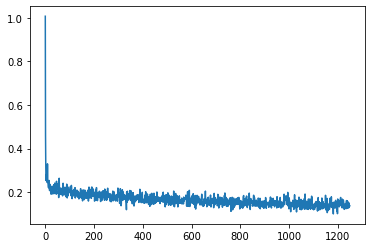

In [276]:
import matplotlib.pyplot as plt
plt.plot(loss_record)

#validation 평가

In [280]:
test_batch = next(iter(testloader))

audio, label = test_batch
pred = model(audio)

In [278]:
threshold = 0.5
pred_thresh = (pred > threshold).float()
match_or_not = (pred_thresh == label)

match_or_not.sum() / (pred.shape[0] * pred.shape[1])

tensor(0.9469)

In [281]:
sample_id = 3
print(trainset.vocab[torch.where(pred_thresh[sample_id])[0]])

audio, label = testset[sample_id]
ipd.display(ipd.Audio(audio, rate=testset.sr))

['guitar' 'piano' 'slow']


# ROC-AUC

In [294]:
def get_tpr_fpr(pred, target, threshold):
  thresh_pred = pred > threshold

  num_total_gt_true = target.sum() # TT
  num_total_gt_false = (1-target).sum() # TF
  num_true_positive = ((target==1) * (thresh_pred==1)).sum() # TP
  print(num_true_positive)
  num_false_positive = ((target==0) * (thresh_pred==1)).sum() # FP
  print(num_true_positive / num_total_gt_true)
  true_positive_ratio = num_true_positive / num_total_gt_true
  false_positive_ratio = num_false_positive / num_total_gt_false

  return true_positive_ratio.item(), false_positive_ratio.item()

get_tpr_fpr(pred, label, threshold=0.6)


tensor(8)
tensor(1.3333)


(1.3333333730697632, 1.2727272510528564)

In [295]:
roc = [ get_tpr_fpr(pred, label, i/100) for i in range(100)]
roc[:10]

tensor(384)
tensor(64.)
tensor(204)
tensor(34.)
tensor(170)
tensor(28.3333)
tensor(151)
tensor(25.1667)
tensor(132)
tensor(22.)
tensor(124)
tensor(20.6667)
tensor(117)
tensor(19.5000)
tensor(109)
tensor(18.1667)
tensor(103)
tensor(17.1667)
tensor(97)
tensor(16.1667)
tensor(91)
tensor(15.1667)
tensor(88)
tensor(14.6667)
tensor(85)
tensor(14.1667)
tensor(79)
tensor(13.1667)
tensor(74)
tensor(12.3333)
tensor(71)
tensor(11.8333)
tensor(69)
tensor(11.5000)
tensor(66)
tensor(11.)
tensor(62)
tensor(10.3333)
tensor(55)
tensor(9.1667)
tensor(51)
tensor(8.5000)
tensor(47)
tensor(7.8333)
tensor(45)
tensor(7.5000)
tensor(44)
tensor(7.3333)
tensor(41)
tensor(6.8333)
tensor(38)
tensor(6.3333)
tensor(35)
tensor(5.8333)
tensor(33)
tensor(5.5000)
tensor(32)
tensor(5.3333)
tensor(31)
tensor(5.1667)
tensor(30)
tensor(5.)
tensor(29)
tensor(4.8333)
tensor(27)
tensor(4.5000)
tensor(25)
tensor(4.1667)
tensor(25)
tensor(4.1667)
tensor(23)
tensor(3.8333)
tensor(22)
tensor(3.6667)
tensor(21)
tensor(3.5000)
tens

[(64.0, 64.0),
 (34.0, 32.931819915771484),
 (28.33333396911621, 25.113636016845703),
 (25.16666603088379, 21.136363983154297),
 (22.0, 18.409090042114258),
 (20.66666603088379, 16.227272033691406),
 (19.5, 14.045454978942871),
 (18.16666603088379, 12.568181991577148),
 (17.16666603088379, 11.795454978942871),
 (16.16666603088379, 10.704545021057129)]

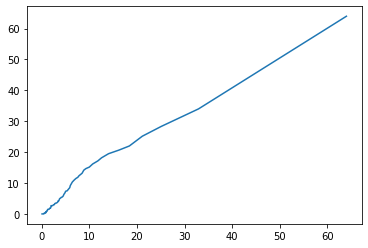

In [296]:
plt.plot([x[1] for x in roc], [x[0] for x in roc])